# Going Deeper 09 Creating a headline for an article in 2 ways
###### 온라인 코어 2기 박수경

이번 과제에서는 기사문을 짧게 요약하는 텍스트 요약 모델을 만들어 보기로 한다. 요약은 추상적 요약과 추출적 요약이 있다. 과제에 필요한 라이브러리를 import 한다.

In [62]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
from summa.summarizer import summarize

print(nltk.__version__)
print(tensorflow.__version__)
print(version('summa'))

3.6.5
2.6.0
1.2.0


In [63]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

import requests

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')


[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Step 1. 데이터 준비   

이번 과제에는 주어진 뉴스 기사 데이터를 사용한다. 
(https://lms.aiffel.io/course/404/node/516/step/3550#:~:text=Step%201.%20%EB%8D%B0%EC%9D%B4%ED%84%B0,%EB%8B%A4%EC%9A%B4%EB%A1%9C%EB%93%9C%ED%95%A0%20%EC%88%98%20%EC%9E%88%EC%96%B4%EC%9A%94.)


In [3]:
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [4]:
data.head(10)

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...
5,Rahat Fateh Ali Khan denies getting notice for...,Pakistani singer Rahat Fateh Ali Khan has deni...
6,"India get all out for 92, their lowest ODI tot...",India recorded their lowest ODI total in New Z...
7,Govt directs Alok Verma to join work 1 day bef...,Weeks after ex-CBI Director Alok Verma told th...
8,Called PM Modi 'sir' 10 times to satisfy his e...,Andhra Pradesh CM N Chandrababu Naidu has said...
9,"Cong wins Ramgarh bypoll in Rajasthan, takes t...",Congress candidate Shafia Zubair won the Ramga...


기사 데이터는 headlines과 text 열로 이루어져 있다.

추상적 요약 : text를 본문, headlines를 요약된 데이터로 삼아서 모델 학습 
추출적 요약 : text열만 사용. (summa 사용)

## Step 2. 추상적 요약 : 데이터 전처리

In [5]:
headlines = data['headlines']
text = data['text']

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98401 entries, 0 to 98400
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headlines  98401 non-null  object
 1   text       98401 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [6]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', text.nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', headlines.nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


Headlines 에서 중복되는 열은 삭제할 필요가 없다.

In [7]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [8]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [9]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


**텍스트 정규화와 불용어 제거**  
텍스트 정규화(축약어, 같은 뜻인 단어들을 하나로 통일)

In [10]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [11]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [12]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
 
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


In [13]:
clean_text = []

for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [14]:
clean_headlines= []

for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [15]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('Done')

=3


In [16]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [17]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [18]:
data.to_csv('clean_data.csv') #전처리 후 데이터 백업

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


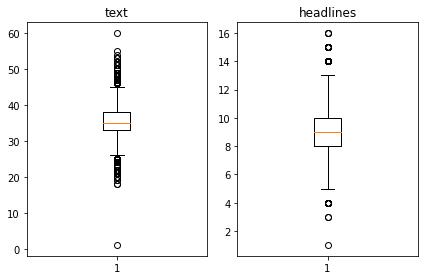

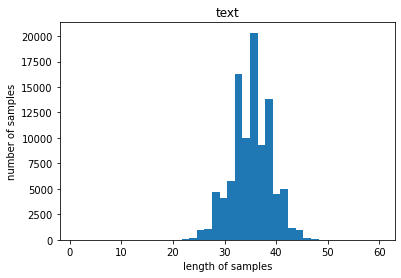

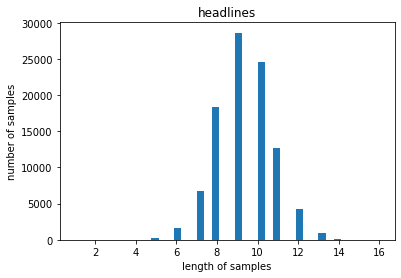

In [19]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

  딱히 분포가 치우쳐져 있지 않아서 지나치게 긴 문장 등을 제외할 필요가 없다고 판단했다.

In [61]:
text_min_len = 5
text_max_len = 55
summary_min_len = 2
summary_max_len = 14
print('Done')

Done


In [60]:
def below_threshold_len(max_len, nested_list, min_len = 0):
  cnt = 0
  for s in nested_list:
    if(min_len <= len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('Done')

Done


In [22]:
below_threshold_len(text_max_len, data['text'], min_len = text_min_len)
below_threshold_len(summary_max_len,  data['headlines'], min_len = summary_min_len)

전체 샘플 중 길이가 55 이하인 샘플의 비율: 0.9999796665311103
전체 샘플 중 길이가 14 이하인 샘플의 비율: 0.9997661651077674


In [23]:
data = data[data['text'].apply(lambda x: text_min_len <= len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: summary_min_len <= len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98336


In [24]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [25]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [26]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[ 9870 58627 42070 ... 86742 92352 13003]


In [27]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('o((>ω< ))o')

o((>ω< ))o


In [28]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19667


In [29]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78669
훈련 레이블의 개수 : 78669
테스트 데이터의 개수 : 19667
테스트 레이블의 개수 : 19667


In [30]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


In [31]:
threshold = 4
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69807
등장 빈도가 3번 이하인 희귀 단어의 수: 40134
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 29673
단어 집합에서 희귀 단어의 비율: 57.49280158150329
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.190051644783529


In [32]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20000로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


In [33]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[87, 26, 4936, 1489, 1792, 1122, 1066, 63, 11, 4342, 3013, 1911, 582, 2143, 267, 13370, 7, 523, 1122, 23, 1066, 498, 461, 1911, 1304, 18402, 203, 1792, 1122, 3712, 11, 1236, 783, 208, 2892, 96, 3321, 1763, 1], [405, 3043, 1016, 1384, 1210, 1452, 385, 9867, 554, 10, 2860, 13371, 229, 1384, 554, 2061, 192, 2729, 1302, 554, 11289, 3390, 1, 1548, 258, 126, 1534, 140, 1641, 36, 548, 16, 173, 131, 301, 1452, 4311, 59], [157, 5436, 105, 924, 1786, 359, 316, 1558, 924, 47, 1167, 887, 1034, 595, 16006, 89, 4, 248, 179, 243, 2269, 6891, 350, 595, 924, 12538, 5551, 16723, 1, 38, 56, 10, 1607, 924, 9676, 56, 357, 7381]]


In [34]:
#빈도수 계산
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


In [35]:
threshold = 10
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30115
등장 빈도가 9번 이하인 희귀 단어의 수: 22420
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 7695
단어 집합에서 희귀 단어의 비율: 74.44794952681389
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 7.078671520753939


In [36]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 451, 772, 2868, 2923, 5, 67, 5, 206, 491], [1, 201, 61, 665, 2187, 1658, 693, 5, 5909, 406, 1505], [1, 63, 583, 477, 373, 4397, 3, 855, 411, 1000], [1, 319, 9505, 8213, 78, 156, 1146], [1, 3929, 786, 9, 4, 1598, 3, 10, 361, 94, 786, 428]]
target
decoder  [[451, 772, 2868, 2923, 5, 67, 5, 206, 491, 2], [201, 61, 665, 2187, 1658, 693, 5, 5909, 406, 1505, 2], [63, 583, 477, 373, 4397, 3, 855, 411, 1000, 2], [319, 9505, 8213, 78, 156, 1146, 2], [3929, 786, 9, 4, 1598, 3, 10, 361, 94, 786, 428, 2]]


In [37]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78669
훈련 레이블의 개수 : 78669
테스트 데이터의 개수 : 19667
테스트 레이블의 개수 : 19667


In [38]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')
print('=3')

=3


In [39]:
encoder_input_train[:5]

array([[   87,    26,  4936,  1489,  1792,  1122,  1066,    63,    11,
         4342,  3013,  1911,   582,  2143,   267, 13370,     7,   523,
         1122,    23,  1066,   498,   461,  1911,  1304, 18402,   203,
         1792,  1122,  3712,    11,  1236,   783,   208,  2892,    96,
         3321,  1763,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [  405,  3043,  1016,  1384,  1210,  1452,   385,  9867,   554,
           10,  2860, 13371,   229,  1384,   554,  2061,   192,  2729,
         1302,   554, 11289,  3390,     1,  1548,   258,   126,  1534,
          140,  1641,    36,   548,    16,   173,   131,   301,  1452,
         4311,    59,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [  157,  5436,   105,   924,  1786,   359,   316,  1558,   924,
           47,  1167,   887,  1034,   595, 16

## Step 3. 추상적 요약 : 모델 작성

In [40]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 256
hidden_size = 512

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [41]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

디코더의 출력층을 구성한다.

In [42]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 55)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 55, 256)      5120000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 55, 512), (N 1574912     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

디코더의 출력층을 지나면 summary가 만들어진다. 마지막 레이어에서 결국 수많은 선택지 중 한 단어를 골라야 하는 다중 클래스 분류 문제를 풀어야 하기 때문에 소프트맥스 활성화함수를 사용한다.  

케라스에서 기본적으로 제공하는 Attention 레이어를 사용했습니다.

In [43]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 55)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 55, 256)      5120000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 55, 512), (N 1574912     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

**모델훈련**

In [44]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [45]:
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=512, callbacks=[es], epochs=50)

Epoch 1/50
154/154 [==============================] - 90s 538ms/step - loss: 4.9849 - val_loss: 4.5544
Epoch 2/50
154/154 [==============================] - 87s 567ms/step - loss: 4.4370 - val_loss: 4.2140
Epoch 3/50
154/154 [==============================] - 87s 567ms/step - loss: 4.0684 - val_loss: 3.9172
Epoch 4/50
154/154 [==============================] - 87s 568ms/step - loss: 3.7572 - val_loss: 3.6708
Epoch 5/50
154/154 [==============================] - 87s 568ms/step - loss: 3.4950 - val_loss: 3.5135
Epoch 6/50
154/154 [==============================] - 88s 569ms/step - loss: 3.2794 - val_loss: 3.3819
Epoch 7/50
154/154 [==============================] - 87s 568ms/step - loss: 3.0936 - val_loss: 3.2937
Epoch 8/50
154/154 [==============================] - 87s 568ms/step - loss: 2.9318 - val_loss: 3.2188
Epoch 9/50
154/154 [==============================] - 87s 568ms/step - loss: 2.7870 - val_loss: 3.1822
Epoch 10/50
154/154 [==============================] - 87s 568ms/step - l

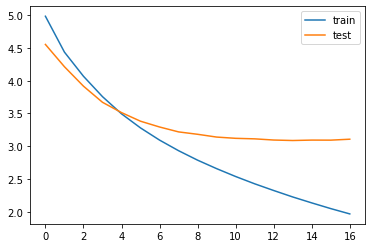

In [46]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [47]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


In [48]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


In [49]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


In [50]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


## Step 4. 추상적 요약 : 결과 비교

In [51]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


In [134]:
for i in range(300, 350):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : villages haryana rewari ruled practicing lawyer help accused year old cbse topper gangrape case also wrote haryana governor seeking strict action accused police arrested three people including main accused doctor villager whose property incident happened nnn 
실제 요약 : no lawyers for accused in gangrape case 
예측 요약 :  hc orders fir against yr old for rape in maha


원문 : announcing post poll alliance jd karnataka assembly elections congress announced support jd supremo deve gowda son hd kumaraswamy chief minister post according reports congress reportedly plans appoint dalit candidate post deputy cm congress jd collectively seats bjp constituencies 
실제 요약 : cong supports jd chief son as cm cong pick to be dy cm 
예측 요약 :  jd to contest cm against taka cm for taka polls


원문 : markets regulator sebi imposed penalty lakh vinay agrawal former official ing bank violating insider trading regulations agrawal traded banks shares valuing lakh four times august may agrawal failed disclose deal

## Step 5. 추출적 요약 : Summa

In [64]:
data2 = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [65]:
data2.sample(20)

,headlines,text
95464,My relationship with Julian Assange is no secr...,Actress-model Pamela Anderson in her blog wrot...
34186,Woman spends Ã¢ÂÂ¹26 lakh on surgeries to loo...,"A 34-year-old American woman has spent $40,000..."
87880,Zaheer best option for India fast bowling coac...,Spinner Harbhajan Singh has said that pacer Za...
78549,Mansion from 1900s on sale for over Ã¢ÂÂ¹100 ...,"A 10,313 square-foot mansion in US' San Franci..."
65647,Researchers create digital objects from incomp...,Germany-based researchers working with US chip...


In [67]:
data2['text'].to_csv('data2.txt')

In [72]:
# text = open('data2.txt','r')

In [73]:
# article  = text.read()

In [78]:
data2['text'][0]

"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."

In [143]:
df = pd.DataFrame(index = range(len(data2['text'])), columns = {'text','headline'})
df['text'] = data2['text']

for i in range(len(data2['text'])):
    a = summarize(data2['text'][i], language='english', words = 12)
    df['headline'][i] = a
    if len(df['headline'][i]) == 0 :       
        b = keywords.keywords(data2['text'][i])
        b = b.replace('\n',' ')                     
        df['headline'][i] = b

In [141]:
from summa import keywords

b =  keywords.keywords(data2['text'][46501])
b = b.replace('\n',' ')
b
# summarize(data2['text'][42], language='english', ratio = 0.05)

'cricket african cricketer international daan'

In [144]:
df.sample(20)

,headline,text
2206,matches match cricketer cricket bhembre poorv ...,"Former Ranji cricketer Rajesh Ghodge, who repr..."
89528,fan wearing,A fan of Gujarat Lions captain Suresh Raina in...
53116,Nokia has unveiled a sleep tracking system cal...,Nokia has unveiled a sleep tracking system cal...
28315,Adding that the US will impose more sanctions ...,US Ambassador to the UN Nikki Haley on Wednesd...
30233,"Playing in his 291st T20, Dhoni surpassed form...",CSK captain MS Dhoni has set the record for mo...
86761,afghanistan wednesday believes mohammad,Afghanistan's President Mohammad Ashraf Ghani ...
18049,pradesh topped uttar bureau,Uttar Pradesh topped the list of gay sex cases...
6959,ravichandran ashwin failed indian spinner shake,Indian spinner Ravichandran Ashwin failed to s...
18594,"Meanwhile, the Gujarat government met several ...",Patidar leader Hardik Patel has reportedly los...
28351,subramanian mp swamy,BJP MP Subramanian Swamy has accused the Congr...


## Discussion

- **전처리 후 데이터 백업**   
 전처리를 하는데 너무 오래 걸려서 전처리를 하고 나서 clean한 데이터를 to_csv()로 백업해 두었다. 이후 전처리를 두 번 할 필요없이 다시 그 파일을 읽어 와 모델 학습을 다시 하니 훨씬 편했다.  

- **프리패딩, 포스트패딩**    
 패딩을 시퀀스의 앞에서부터 줄지, 뒤에서부터 줄지 정할 수 있었다.  두가지 다 시도해 보았는데 'pre'로, 앞에서부터 패딩을 채웠을 때 결과가 형편없었다. 'will not be able to do more as an show kohli on kohli'을 일괄적으로 출력할 뿐이었다.Threshold나 시퀀스의 max_len등을 조절해보았지만 좋은 결과를 얻을 수 없었다. 프리패딩, 포스트패딩에 대해 조금 더 잘 알고 싶다. 
 ![](img2.PNG)  



- **summa 요약을 위한 전처리**    
summa는 온점을 기준으로 문장으로 인식한다. 따라서 전처리할 때 온점을 삭제하면 안되며, 소문자 처리와 특수문자만 없애야 한다.


- **summa 키워드 적용시, 헤드라인으로 서머리를 작성할 때의 문제점 발생**    
 summa의 요약 기능으로 추출적 요약을 실행할 시, ratio 나 word 수에 따라 요약이 제대로 되지 않는 경우가 많이 발생했다. ratio를 높이거나 words 를 크게 주었을 때 요약문을 추출해 내기는 하지만 헤드라인은 기사의 제목으로, 너무 길어져 버리면 의미가 없다고 생각했다. 그래서 아래 첨부한 것처럼 적절한 길이의 헤드라인을 먼저 요약하고, 제대로 요약이 되지 않아 headline 열이 비어 있으면, 키워드를 추출하여 대신 헤드라인을 삼는 방법을 사용하였다.  여러가지 조건을 나누거나 전처리를 적절히 하면 더 좋은 방법이 있을 것 같았으나 summa 의 summarizer를 커스텀하는 데에는 한계가 있었다.  다음에는 짧은 헤드라인을 만드는 방법으로 조금 더 다양한 방법을 시도해 보고 싶다.  
 ![](img1.PNG)
 
 
- **고유명사**   
 대문자로 시작하는 수많은 고유명사들은 모든 철자를 소문자화 할 때 의미의 변형, 손상이 있을수도 있으며 모델이 혼동을 일으키게 할 수도 있는 것 같다. 만약 문장의 가장 앞의 대문자만 소문자화 하고 문장 중간에 고유명사 속의 대명사는 그대로 두는 전처리를 하면 조금 더 효과적일까? 시간에 쫓겨서 시도해보지 못했지만 한 번 시도해 보고 싶다. if 문을 사용하면 될 것 같은데 시간은 굉장히 많이 걸릴 것 같다.(다 읽어야 하므로)  
 
- **AdditiveAttention layer**    
 어텐션 메커니즘이 어떻게 장기 기억을 가지고 가는지에 대해 알 수 있었다. 그렇지만 사용하는 것은 케라스에서 제공하는 레이어를 불러와 가이드라인이 제시하는 쪽에 집어넣어 본 것이 다여서 조금 더 잘 알고 싶다는 생각이 들었다. 


## References

- https://ai.googleblog.com/2016/08/text-summarization-with-tensorflow.html (Text summarization with TensorFlow)   
- https://pypi.org/project/summa/ (summa 쓰는 법)  
-https://www.tensorflow.org/api_docs/python/tf/keras/layers/AdditiveAttention (어텐션 레이어)